In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [ ]:
#pip install lazypredict

In [1]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [3]:
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","skyl1_o"],
                          parse_dates=["time"]).dropna().set_index("time")
station                          

skyl1_o
time                       
2018-01-01 00:00:00   914.0
2018-01-01 00:30:00       M
2018-01-01 01:00:00       M
2018-01-01 01:30:00       M
2018-01-01 02:00:00       M
...                     ...
2022-12-30 21:30:00   549.0
2022-12-30 22:00:00   640.0
2022-12-30 22:30:00   640.0
2022-12-30 23:00:00   732.0
2022-12-30 23:30:00   732.0

[89597 rows x 1 columns]

In [10]:
#@title Load station (Cloud level 1 height). Load meteorological model forecast D0.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","skyl1_o"],
                          parse_dates=["time"]).dropna().set_index("time")
#clouds height meters to feet
num = pd.to_numeric(station.skyl1_o, errors="coerce")*3.28084

#label more or less than 200 feet
interval = pd.IntervalIndex.from_tuples([(-1, 300),(300,7000)])
labels = ["<=300ft",">300ft"]


station["skyl1_l"] = pd.cut(num, bins=interval,retbins=False,labels=labels)
station["skyl1_l"] = station["skyl1_l"].map({a:b for a,b in zip(interval,labels)})
station["skyl1_l"] = station["skyl1_l"].astype(str).replace("nan","No Cloud")
station["skyl1_l"] = pd.Categorical(station["skyl1_l"])
print("\nCloud height frequencies")
display(station["skyl1_l"].value_counts(normalize=True).map(lambda n: '{:.1%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()






Cloud height frequencies


>300ft      63.8%
No Cloud    32.4%
<=300ft      3.8%
Name: skyl1_l, dtype: object

In [11]:
df_all

skyl1_l        dir0  snow_prec0   snowlevel0       mod0  \
time                                                                            
2018-01-01 01:00:00  No Cloud  215.747849         0.0   902.306519   5.105255   
2018-01-01 02:00:00  No Cloud  215.917984         0.0   914.343018   5.875232   
2018-01-01 03:00:00  No Cloud  223.666367         0.0   940.227722   5.960269   
2018-01-01 04:00:00  No Cloud  228.431320         0.0   956.362671   6.237044   
2018-01-01 05:00:00    >300ft  233.394775         0.0  1000.156311   6.957641   
...                       ...         ...         ...          ...        ...   
2022-12-30 19:00:00    >300ft  205.438812         0.0  2140.130859  10.966944   
2022-12-30 20:00:00    >300ft  205.519791         0.0  2128.530762  10.623146   
2022-12-30 21:00:00    >300ft  203.523941         0.0  2142.092529  10.237870   
2022-12-30 22:00:00    >300ft  201.616959         0.0  2121.737793   9.658238   
2022-12-30 23:00:00    >300ft  196.627472         0.0  2122.162842   9.923582   

                     wind_gust0          mslp0       temp0       rh0  \
time                                                                   
2018-01-01 01:00:00   13.569287  102718.562500  283.712128  0.804692   
2018-01-01 02:00:00   14.852463  102704.343750  284.151947  0.809324   
2018-01-01 03:00:00   14.331568  102696.648438  284.475311  0.807002   
2018-01-01 04:00:00   15.082509  102694.281250  284.740265  0.815113   
2018-01-01 05:00:00   15.846083  102686.031250  285.119202  0.827759   
...                         ...            ...         ...       ...   
2022-12-30 19:00:00   20.408443  101224.937500  289.855621  0.844320   
2022-12-30 20:00:00   20.809048  101283.632812  289.902374  0.844684   
2022-12-30 21:00:00   20.840071  101280.671875  289.717926  0.853459   
2022-12-30 22:00:00   19.937672  101289.281250  289.617004  0.854495   
2022-12-30 23:00:00   20.322779  101273.460938  289.326935  0.857122   

                      visibility0  ...      cape3       cin3  cfh3      cfl3  \
time                               ...                                         
2018-01-01 01:00:00  24051.365234  ...   0.000000  -0.000477   0.2  0.000000   
2018-01-01 02:00:00  24039.359375  ...   3.170000 -34.650459   0.2  0.000000   
2018-01-01 03:00:00  24040.320312  ...  17.260000 -24.117239   0.3  0.101562   
2018-01-01 04:00:00  24042.085938  ...  30.129999 -19.603157   0.3  0.429688   
2018-01-01 05:00:00  24040.648438  ...  50.369999 -10.988547   0.2  0.000000   
...                           ...  ...        ...        ...   ...       ...   
2022-12-30 19:00:00  24038.054688  ...   0.000000   0.000000   0.2  0.320312   
2022-12-30 20:00:00  24036.107422  ...   1.280000  -8.179551   0.3  0.500000   
2022-12-30 21:00:00  24234.943359  ...   0.000000   0.000113   0.6  0.437500   
2022-12-30 22:00:00  24234.662109  ...   0.656000  -9.782903   0.6  0.429688   
2022-12-30 23:00:00  24036.123047  ...   1.680000  -2.866535   0.5  0.515625   

                     cfm3      cft3      HGT5003      HGT8503       T5003  \
time                                                                        
2018-01-01 01:00:00   0.0  0.200000  5563.714844  1548.354980  248.946930   
2018-01-01 02:00:00   0.0  0.200000  5569.226074  1547.240967  249.484375   
2018-01-01 03:00:00   0.0  0.300000  5577.497070  1547.338013  249.928879   
2018-01-01 04:00:00   0.0  0.429688  5584.778809  1548.901001  250.126190   
2018-01-01 05:00:00   0.0  0.200000  5587.893066  1549.415039  250.114441   
...                   ...       ...          ...          ...         ...   
2022-12-30 19:00:00   0.0  0.320312  5593.541016  1449.093994  256.560760   
2022-12-30 20:00:00   0.0  0.500000  5598.160156  1454.644043  257.004120   
2022-12-30 21:00:00   0.0  0.600000  5602.586914  1453.765991  257.113007   
2022-12-30 22:00:00   0.0  0.600000  5604.122070  1452.741943  257.041443   
2022-12-30 23:00:00   0.0  0.515625  5603.122070  1450.875000  257

Round 0


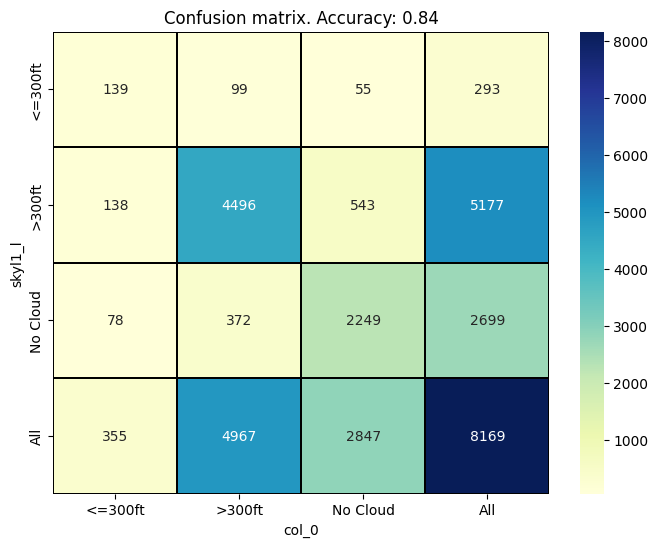

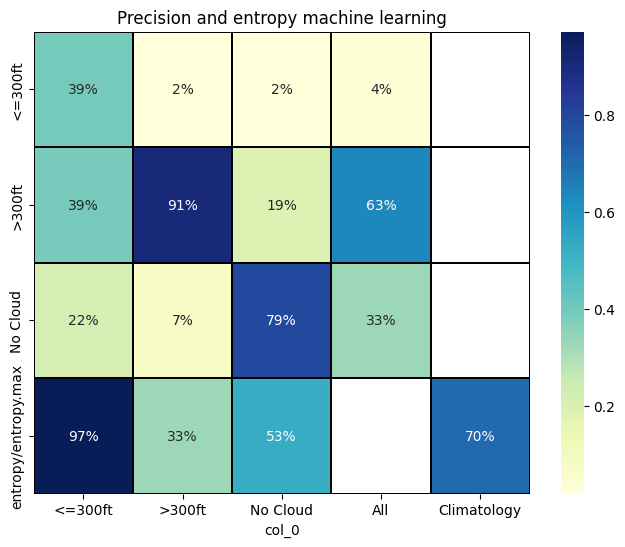

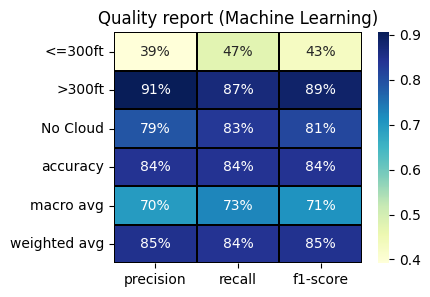

feature feature_per
102  dayofyear        4.3%
100       hour        3.2%
50        dir2        2.3%
0         dir0        2.1%
57         rh2        1.9%
7          rh0        1.7%
75        dir3        1.7%
101      month        1.5%
39      shflx1        1.5%
21     HGT5000        1.5%

Round 1


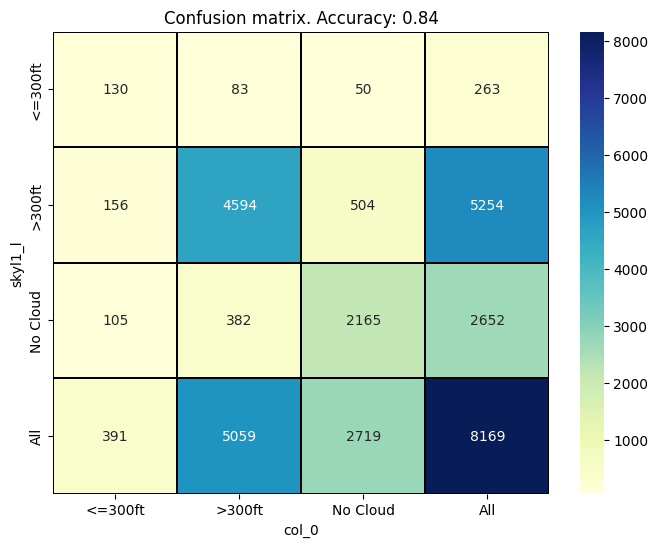

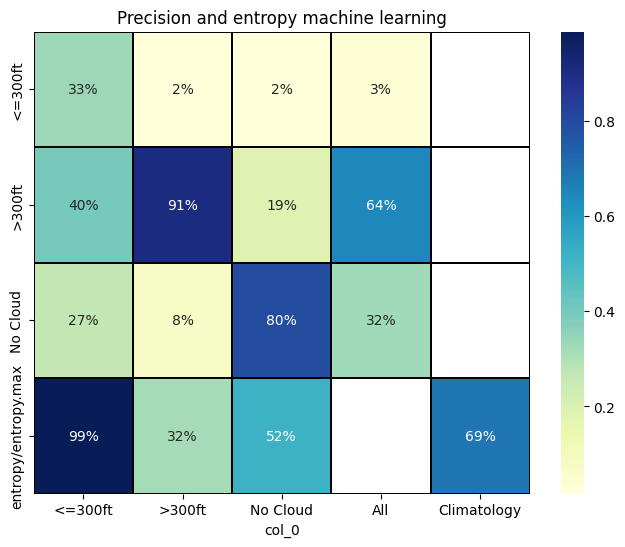

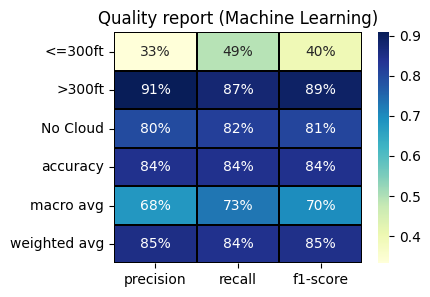

feature feature_per
102   dayofyear        4.2%
100        hour        3.1%
0          dir0        2.1%
50         dir2        1.9%
7           rh0        1.9%
57          rh2        1.8%
39       shflx1        1.7%
49        T8501        1.7%
75         dir3        1.6%
54   wind_gust2        1.5%

Round 2


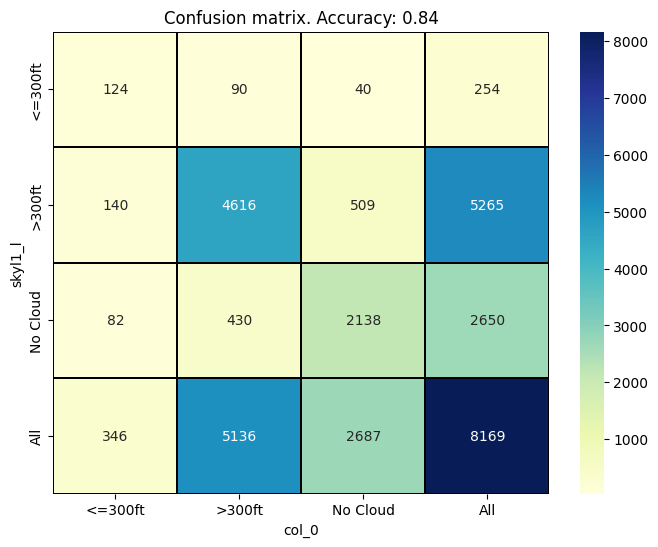

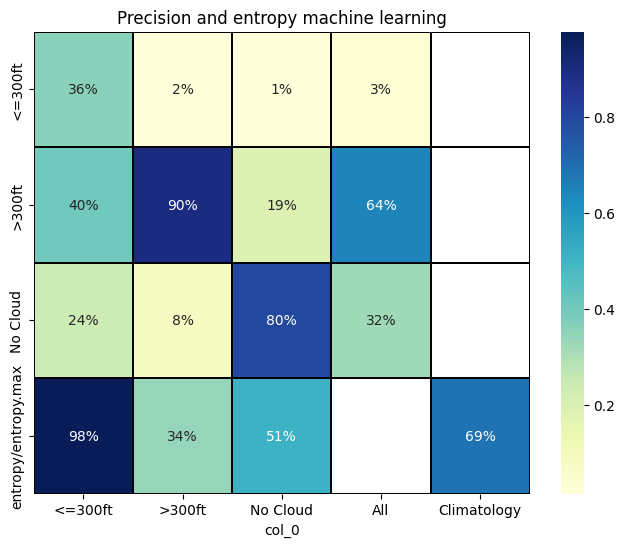

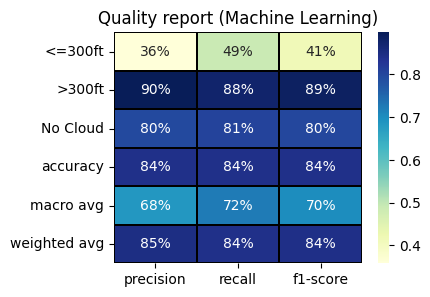

feature feature_per
102   dayofyear        4.2%
100        hour        3.0%
0          dir0        2.2%
50         dir2        2.1%
57          rh2        1.9%
7           rh0        1.6%
75         dir3        1.5%
49        T8501        1.5%
2    snowlevel0        1.5%
39       shflx1        1.5%

Round 3


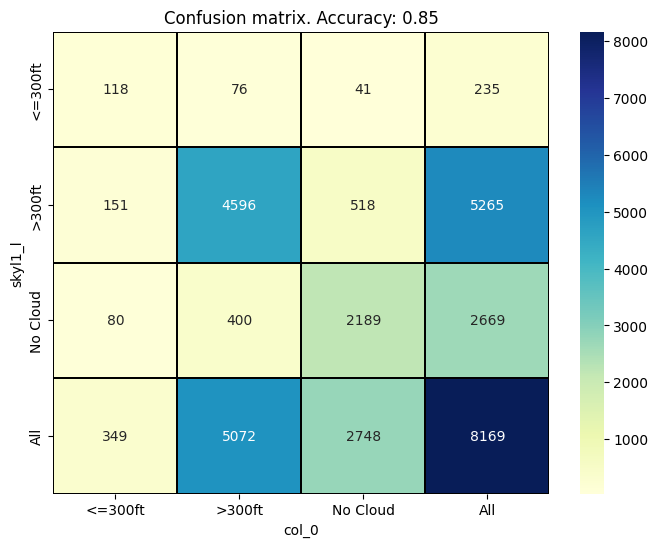

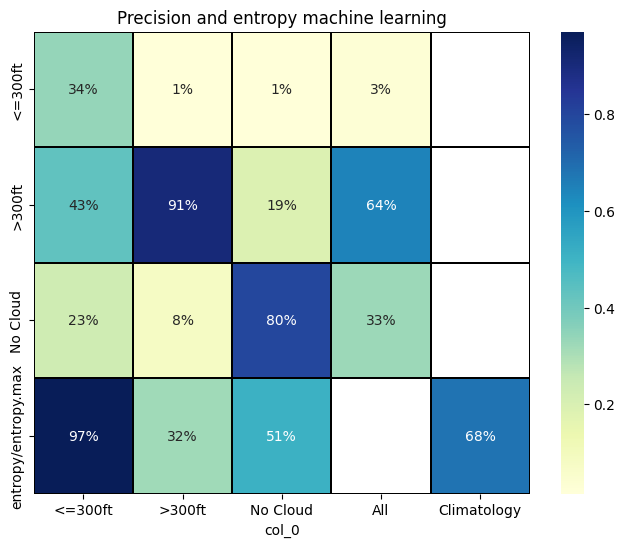

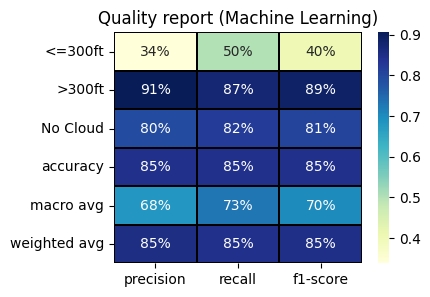

feature feature_per
102   dayofyear        3.9%
100        hour        3.0%
50         dir2        2.3%
0          dir0        2.1%
57          rh2        1.8%
7           rh0        1.8%
75         dir3        1.7%
39       shflx1        1.5%
2    snowlevel0        1.5%
5         mslp0        1.5%

Round 4


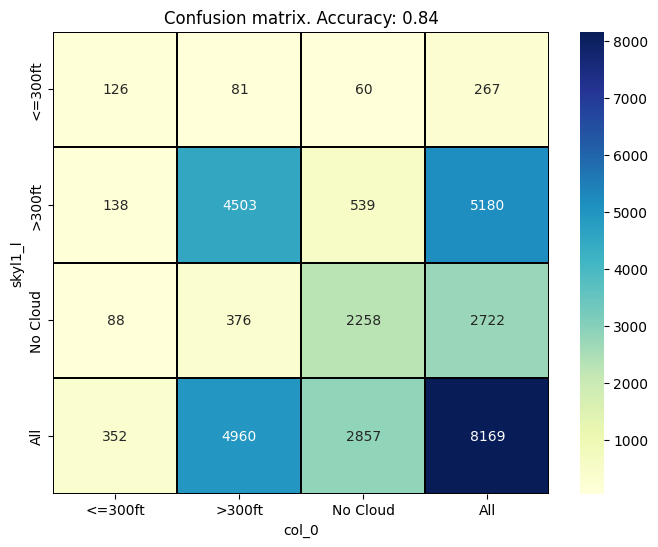

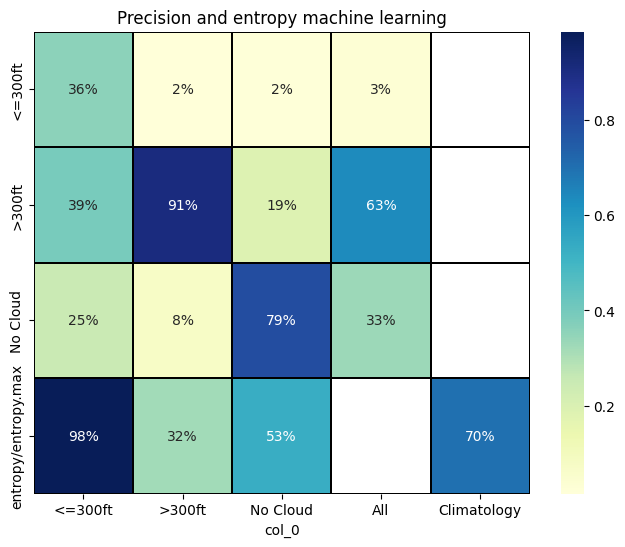

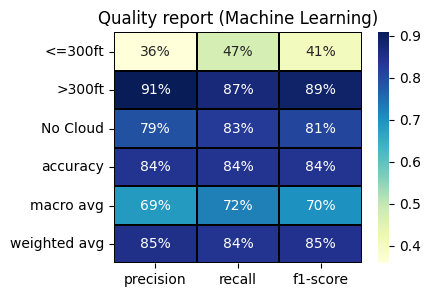

feature feature_per
102   dayofyear        4.4%
100        hour        3.1%
50         dir2        2.3%
0          dir0        2.2%
57          rh2        2.0%
7           rh0        1.7%
75         dir3        1.7%
39       shflx1        1.6%
74        T8502        1.4%
52   snowlevel2        1.4%

Round 5


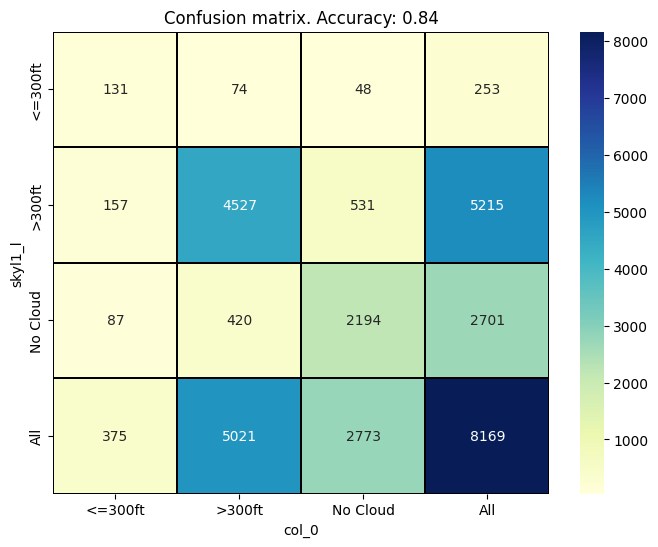

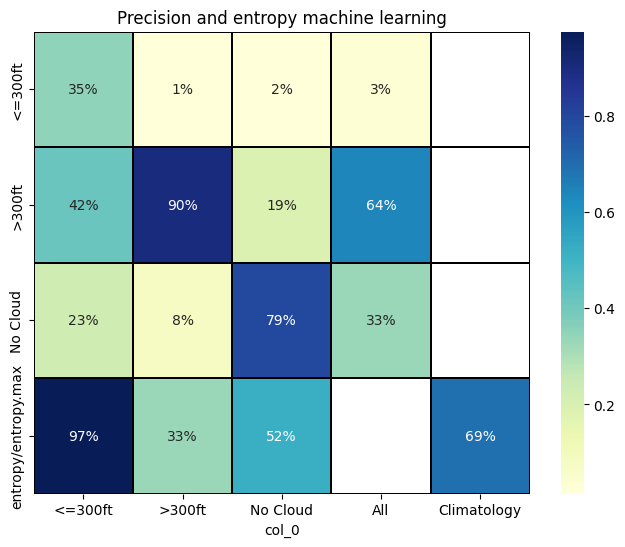

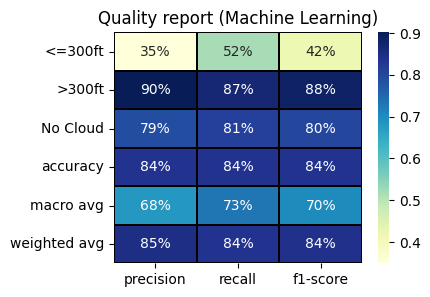

feature feature_per
102  dayofyear        4.5%
100       hour        3.1%
50        dir2        2.2%
0         dir0        2.2%
57         rh2        1.9%
7          rh0        1.6%
75        dir3        1.6%
5        mslp0        1.6%
101      month        1.4%
49       T8501        1.4%

Round 6


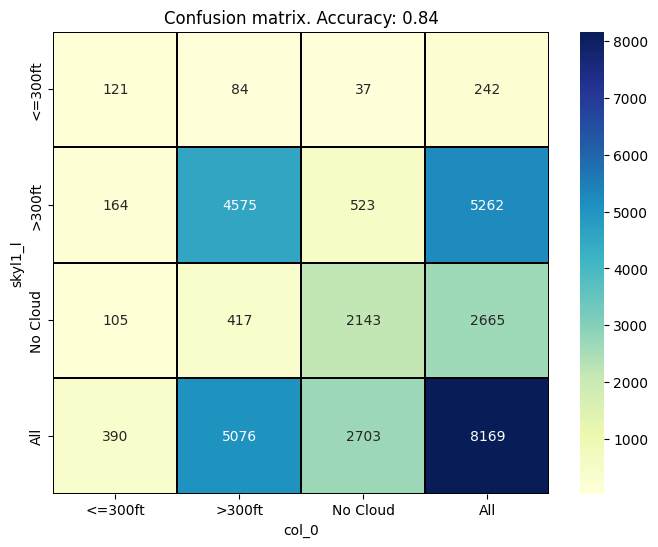

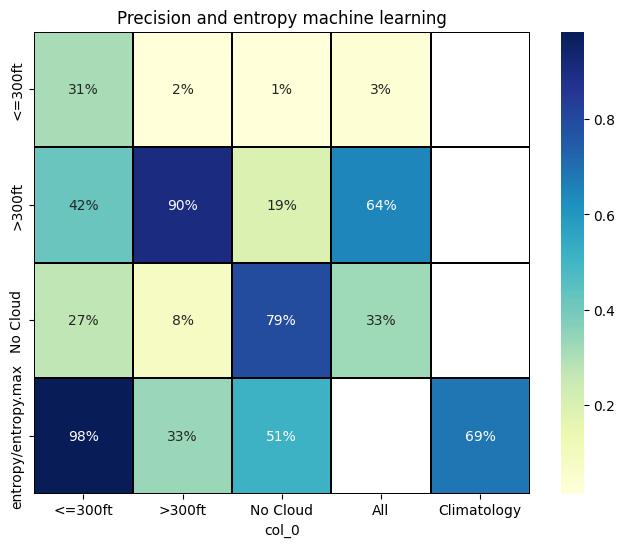

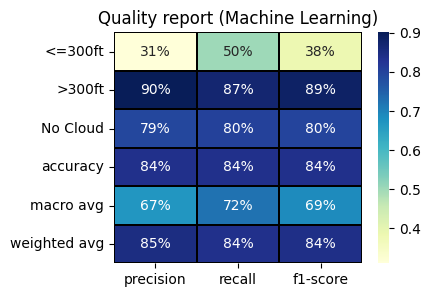

feature feature_per
102   dayofyear        4.2%
100        hour        3.3%
0          dir0        2.2%
50         dir2        2.1%
57          rh2        1.9%
7           rh0        1.7%
39       shflx1        1.6%
49        T8501        1.5%
75         dir3        1.5%
2    snowlevel0        1.5%

Round 7


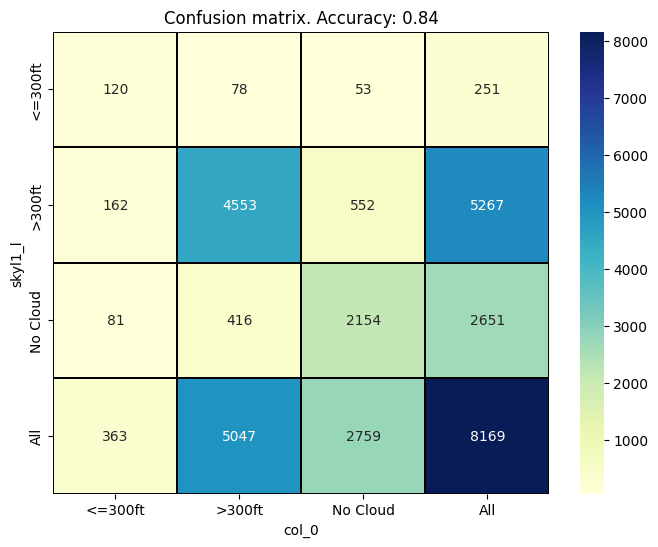

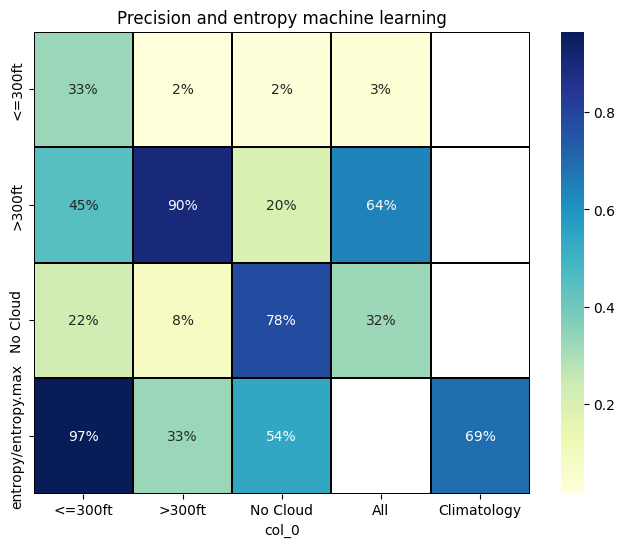

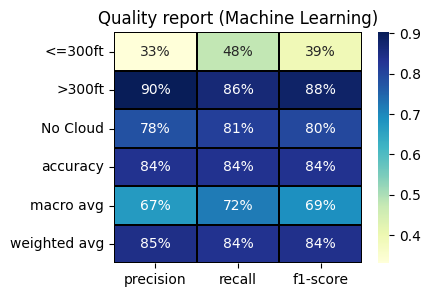

feature feature_per
102  dayofyear        4.1%
100       hour        3.1%
50        dir2        2.3%
57         rh2        2.0%
0         dir0        2.0%
75        dir3        1.7%
7          rh0        1.7%
101      month        1.7%
49       T8501        1.6%
5        mslp0        1.5%

Round 8


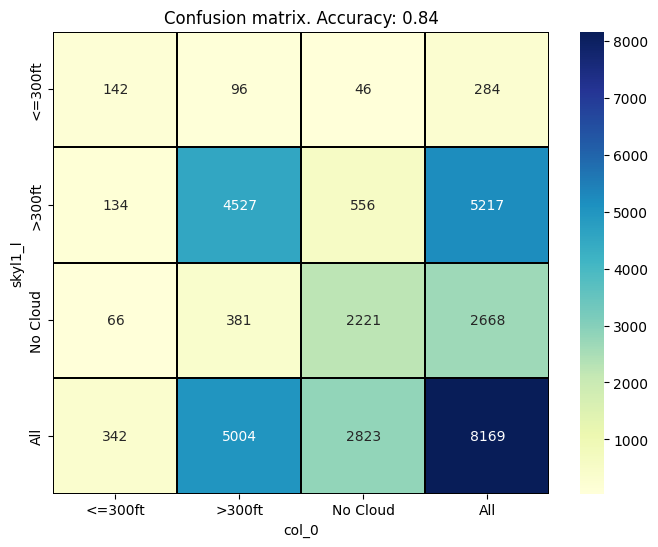

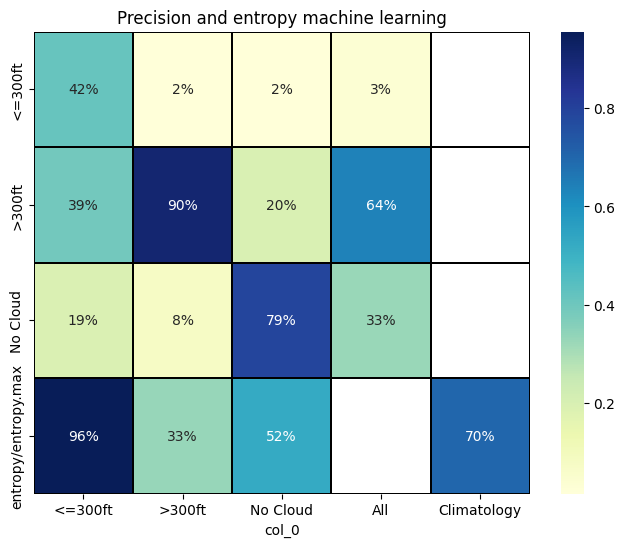

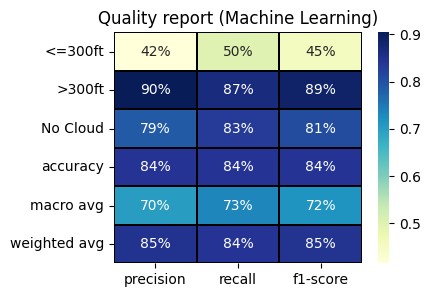

feature feature_per
102  dayofyear        4.2%
100       hour        3.1%
0         dir0        2.1%
7          rh0        2.0%
50        dir2        1.9%
57         rh2        1.9%
75        dir3        1.7%
39      shflx1        1.6%
5        mslp0        1.6%
49       T8501        1.5%

Round 9


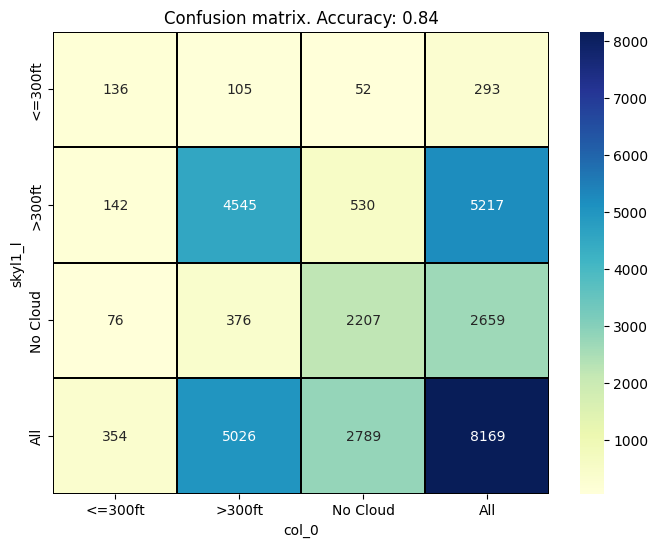

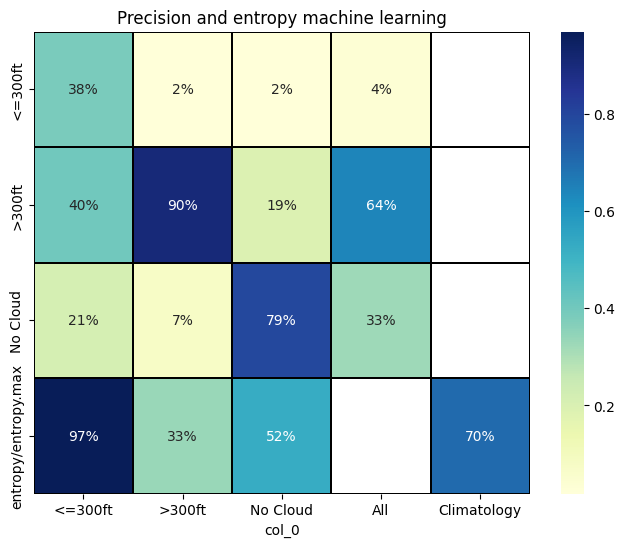

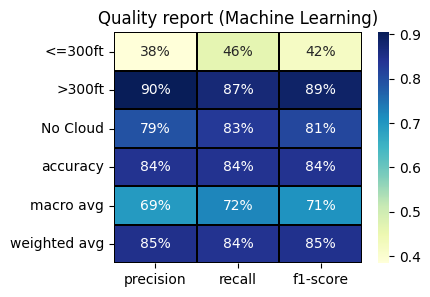

feature feature_per
102   dayofyear        4.3%
100        hour        3.2%
0          dir0        2.1%
57          rh2        2.1%
50         dir2        2.0%
7           rh0        1.7%
101       month        1.6%
2    snowlevel0        1.5%
49        T8501        1.5%
32          rh1        1.5%


Accuracy stadistics
        Accuracy
count  10.000000
mean    0.841000
std     0.003162
min     0.840000
25%     0.840000
50%     0.840000
75%     0.840000
max     0.850000
Shapiro test normality
p value: 1.0036932707180313e-07
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 7.519682010366068e-267
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1217.9872156026051
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 5.93 minutes


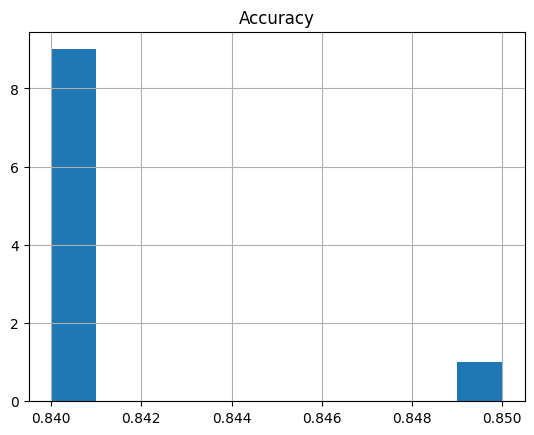

In [12]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int) 

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]
 

# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  
  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [13]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/skyl1_LECO_d0.al", 'wb'))

Round 0


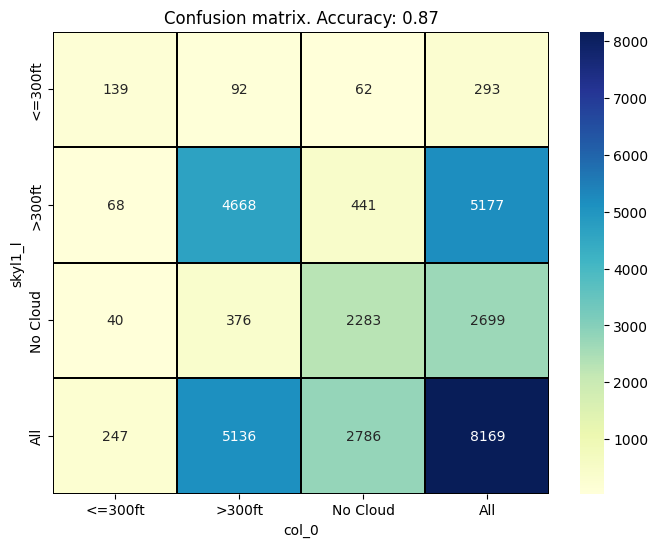

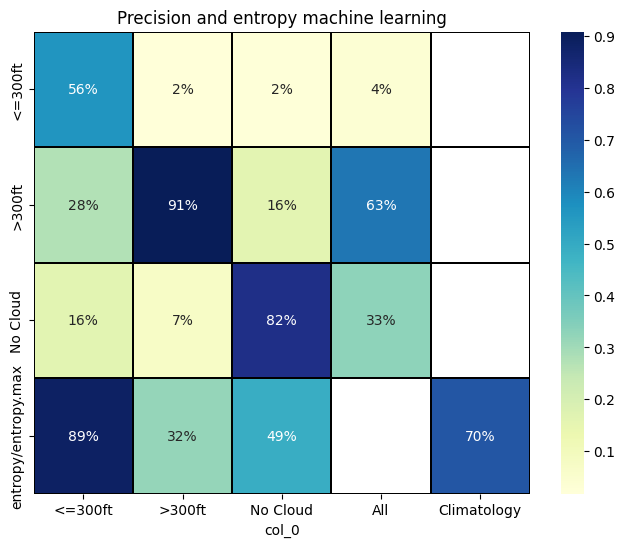

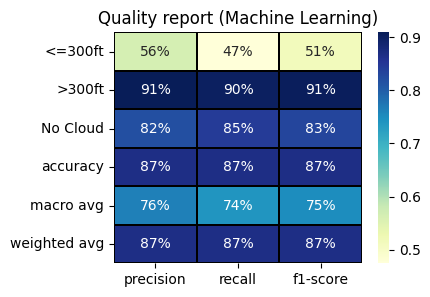

feature feature_per
100        hour        3.0%
43         cfl1        2.2%
4    wind_gust0        2.1%
32          rh1        2.0%
29   wind_gust1        2.0%
7           rh0        1.9%
82          rh3        1.8%
28         mod1        1.8%
57          rh2        1.8%
3          mod0        1.8%

Round 1


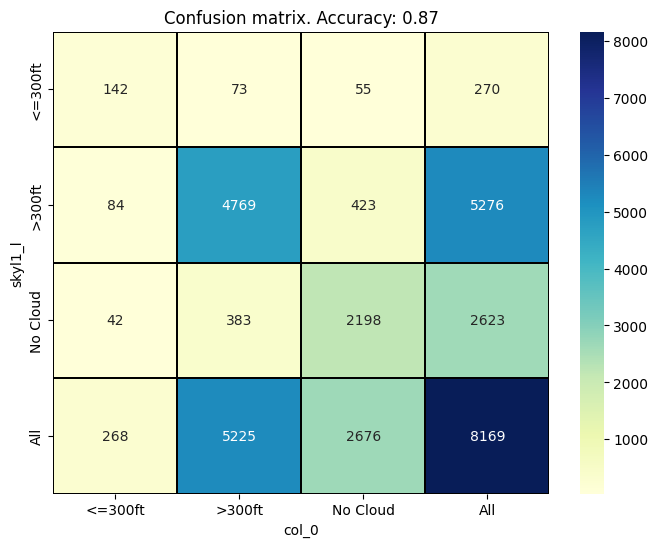

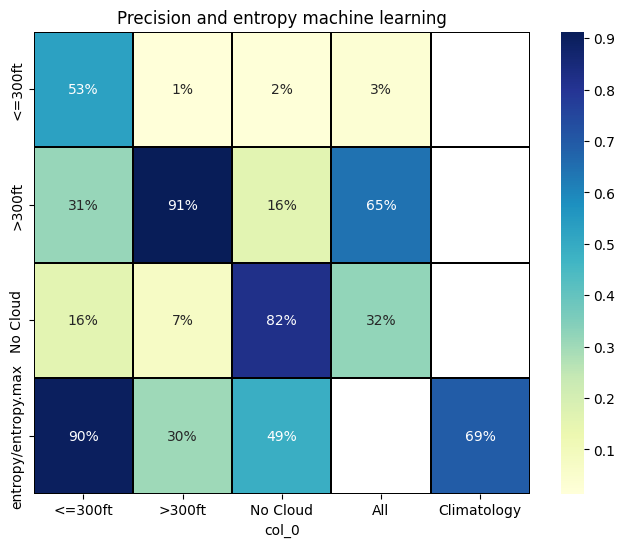

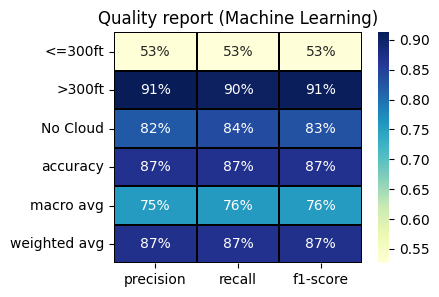

feature feature_per
100        hour        3.1%
18         cfl0        2.1%
7           rh0        2.1%
32          rh1        2.1%
79   wind_gust3        2.0%
82          rh3        2.0%
57          rh2        2.0%
54   wind_gust2        1.9%
29   wind_gust1        1.8%
3          mod0        1.7%

Round 2


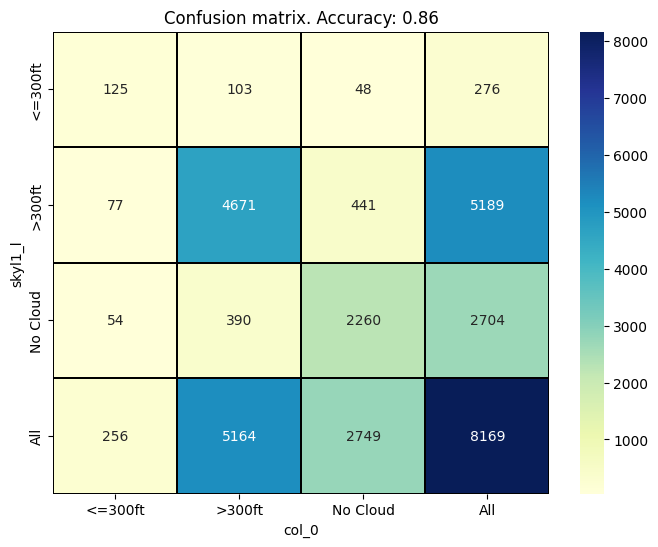

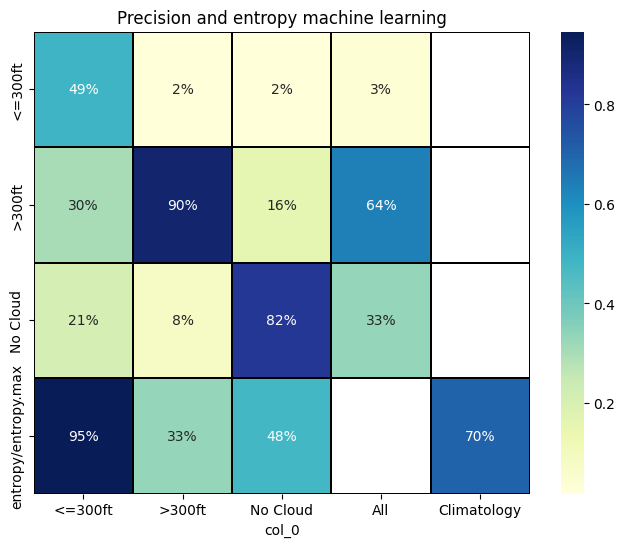

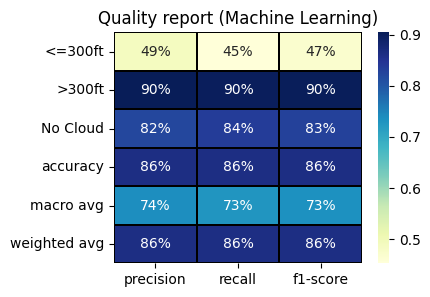

feature feature_per
100        hour        3.1%
7           rh0        2.5%
57          rh2        2.0%
29   wind_gust1        2.0%
54   wind_gust2        2.0%
93         cfl3        2.0%
32          rh1        1.9%
0          dir0        1.9%
18         cfl0        1.8%
43         cfl1        1.7%

Round 3


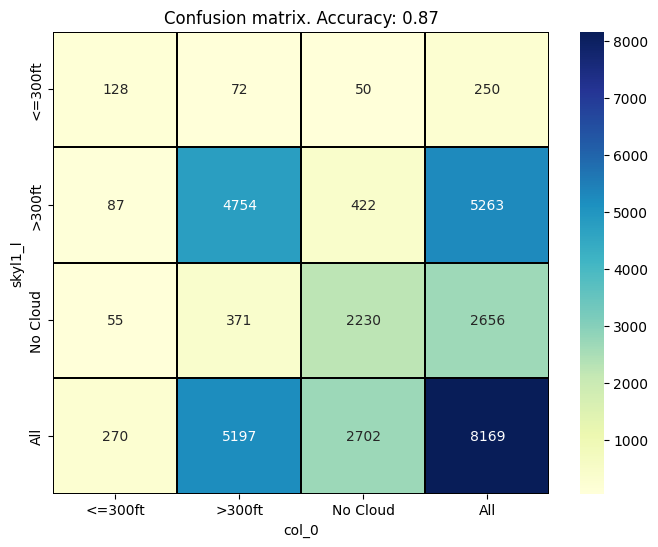

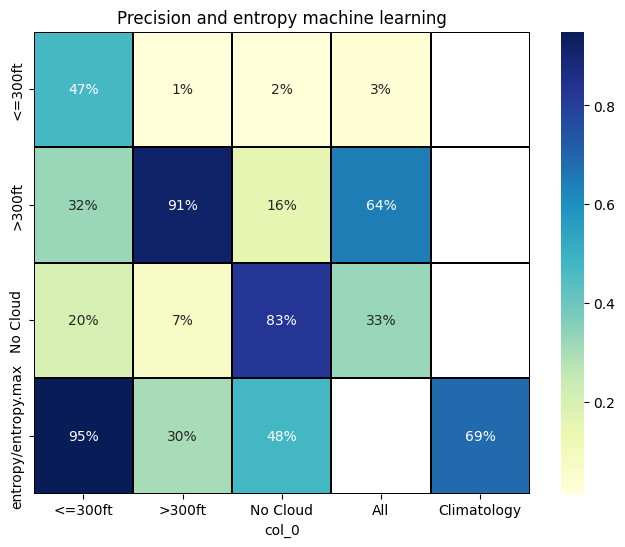

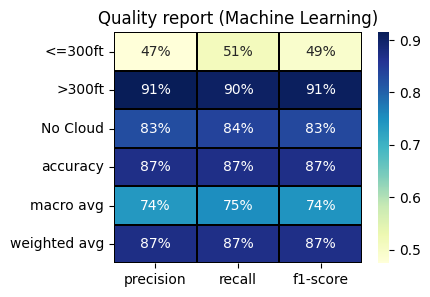

feature feature_per
100        hour        3.1%
43         cfl1        2.2%
32          rh1        2.1%
7           rh0        2.1%
57          rh2        1.9%
29   wind_gust1        1.9%
82          rh3        1.9%
4    wind_gust0        1.8%
0          dir0        1.8%
54   wind_gust2        1.8%

Round 4


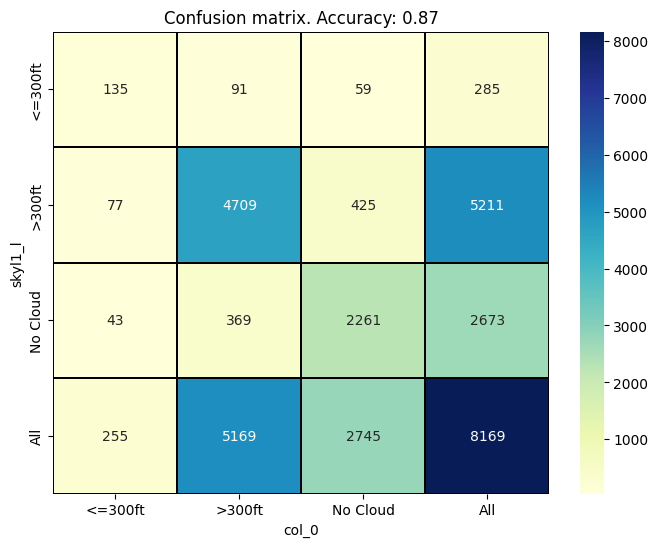

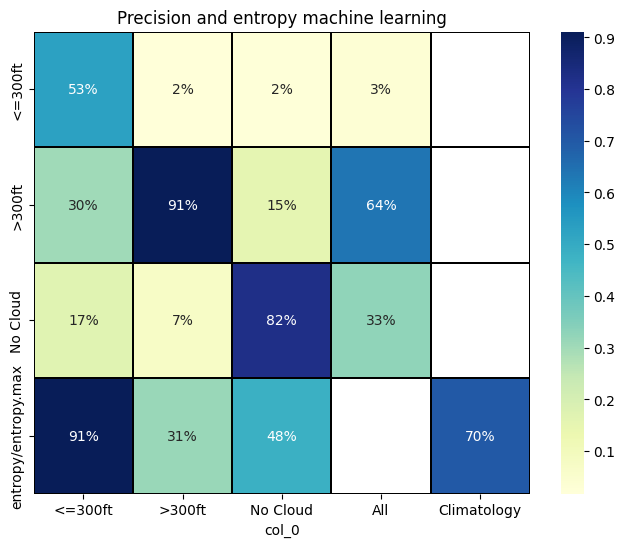

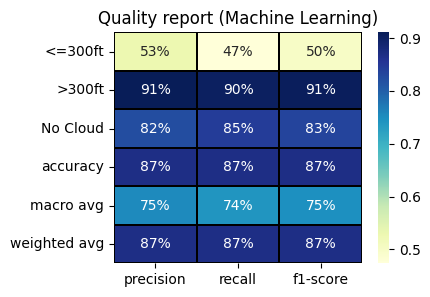

feature feature_per
100        hour        3.4%
7           rh0        2.4%
57          rh2        2.3%
43         cfl1        2.1%
32          rh1        1.9%
0          dir0        1.8%
29   wind_gust1        1.8%
82          rh3        1.8%
4    wind_gust0        1.8%
68         cfl2        1.7%

Round 5


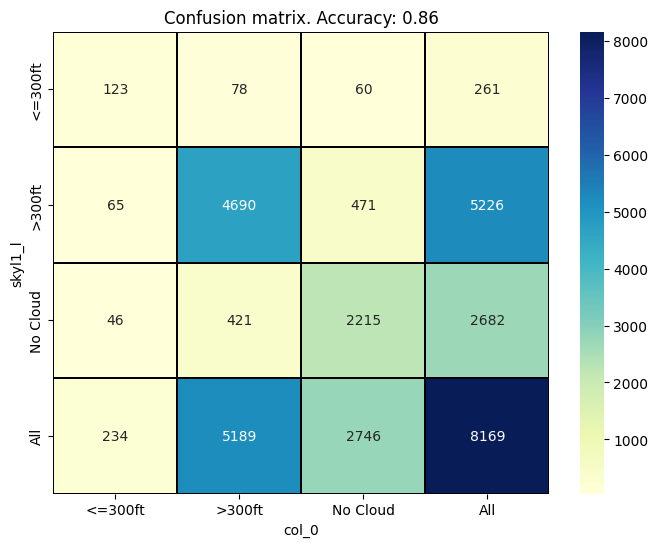

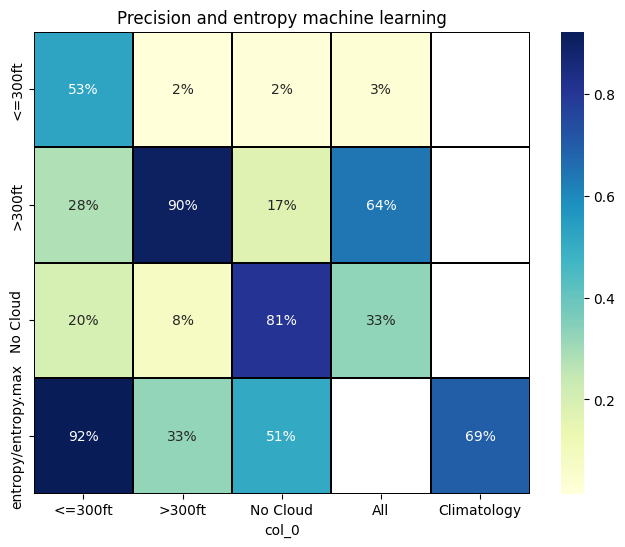

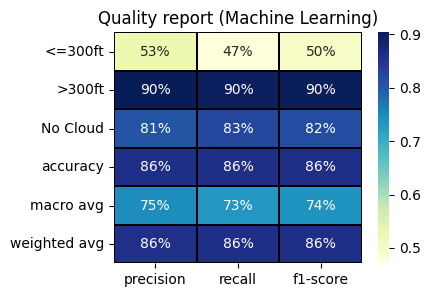

feature feature_per
100        hour        3.0%
7           rh0        2.3%
68         cfl2        2.1%
4    wind_gust0        2.1%
79   wind_gust3        2.0%
29   wind_gust1        1.9%
57          rh2        1.9%
82          rh3        1.9%
0          dir0        1.8%
32          rh1        1.8%

Round 6


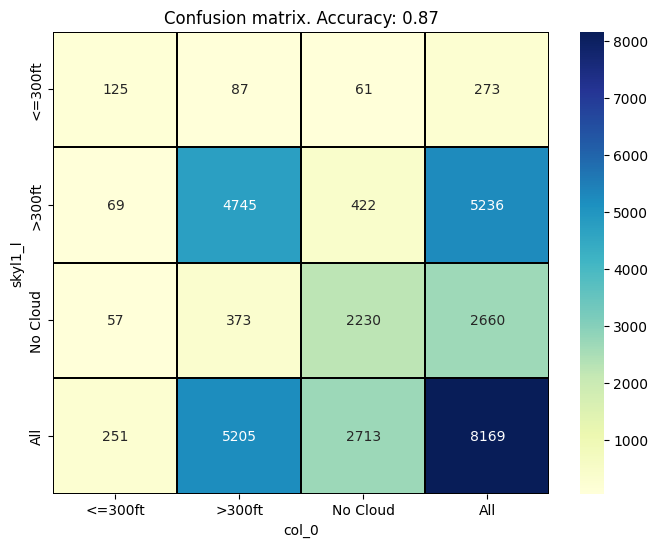

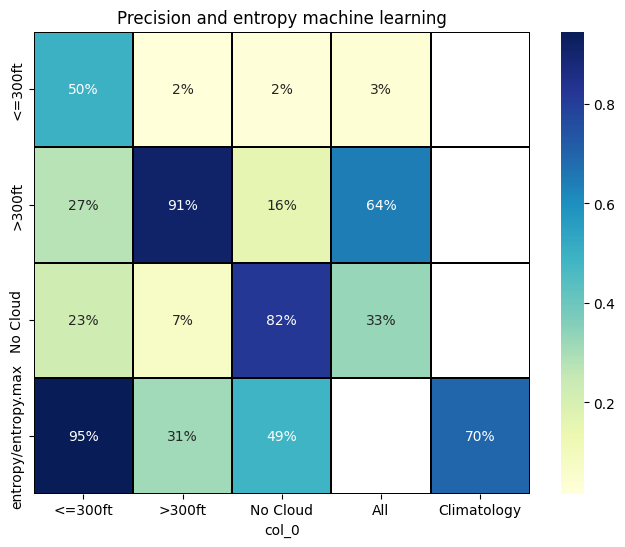

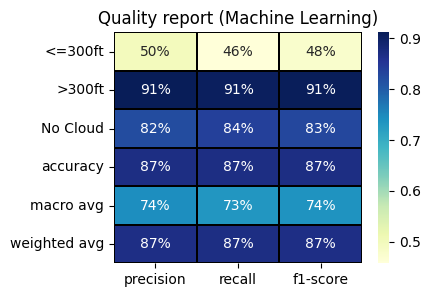

feature feature_per
100        hour        3.1%
7           rh0        2.1%
32          rh1        2.1%
4    wind_gust0        2.0%
68         cfl2        2.0%
57          rh2        2.0%
82          rh3        1.9%
93         cfl3        1.9%
18         cfl0        1.8%
54   wind_gust2        1.8%

Round 7


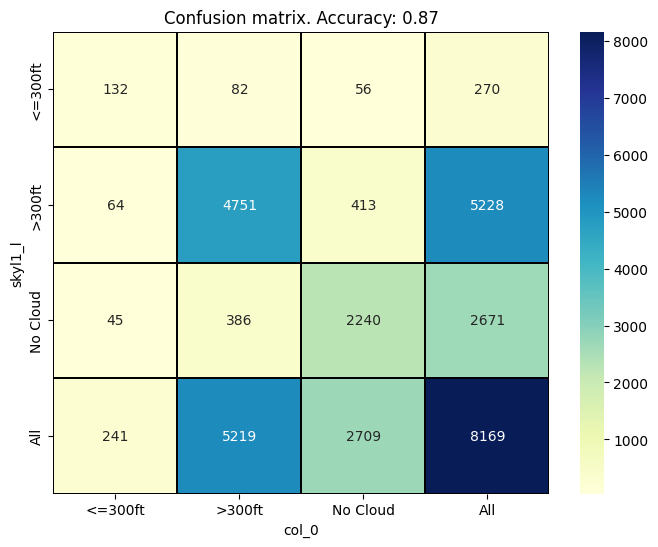

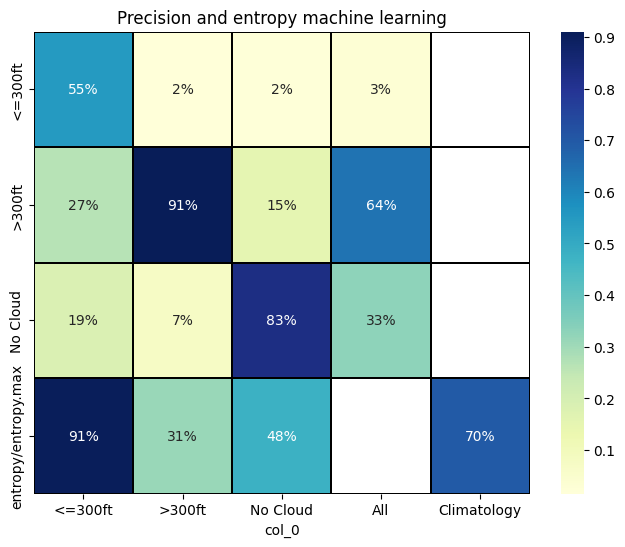

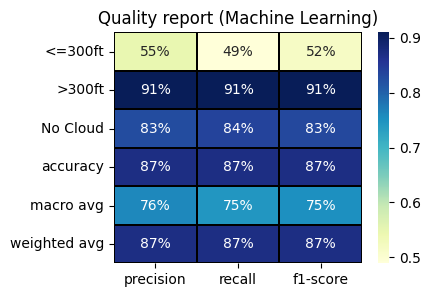

feature feature_per
100        hour        3.4%
93         cfl3        2.1%
18         cfl0        2.1%
57          rh2        2.1%
29   wind_gust1        1.9%
7           rh0        1.9%
82          rh3        1.9%
79   wind_gust3        1.8%
4    wind_gust0        1.8%
3          mod0        1.8%

Round 8


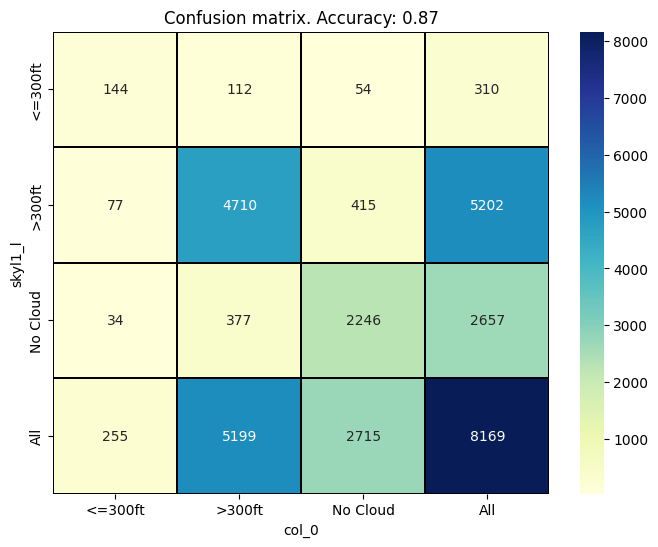

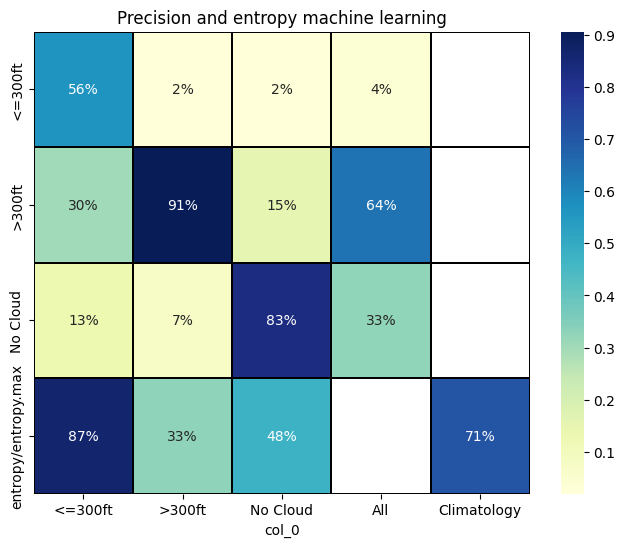

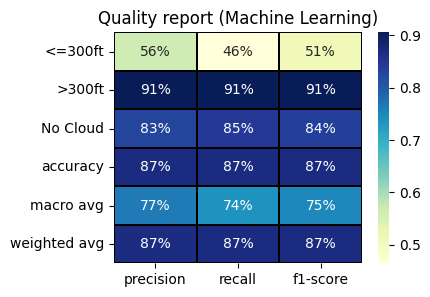

feature feature_per
100        hour        2.9%
32          rh1        2.2%
7           rh0        2.1%
68         cfl2        2.0%
79   wind_gust3        1.8%
3          mod0        1.8%
43         cfl1        1.7%
57          rh2        1.7%
4    wind_gust0        1.7%
18         cfl0        1.7%

Round 9


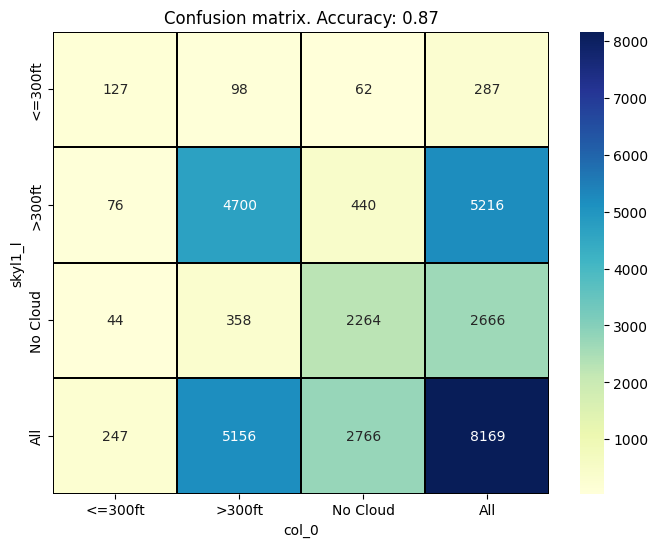

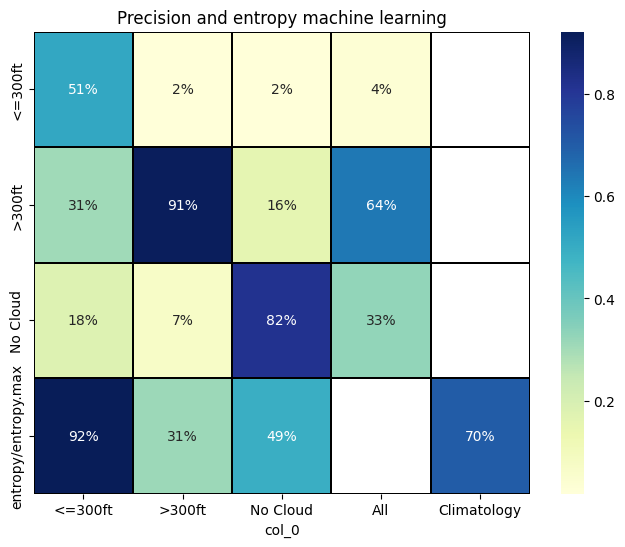

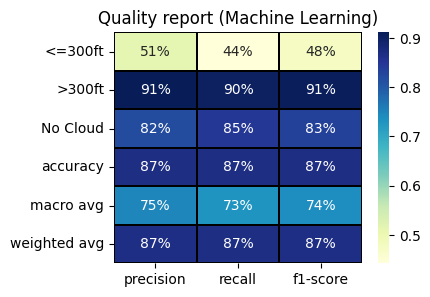

feature feature_per
100        hour        3.1%
4    wind_gust0        2.2%
32          rh1        2.1%
43         cfl1        2.1%
57          rh2        2.0%
93         cfl3        1.9%
7           rh0        1.9%
79   wind_gust3        1.9%
18         cfl0        1.8%
0          dir0        1.7%


Accuracy stadistics
        Accuracy
count  10.000000
mean    0.868000
std     0.004216
min     0.860000
25%     0.870000
50%     0.870000
75%     0.870000
max     0.870000
Shapiro test normality
p value: 4.6723621380806435e-06
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1646.1074119807645
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 5.0 minutes


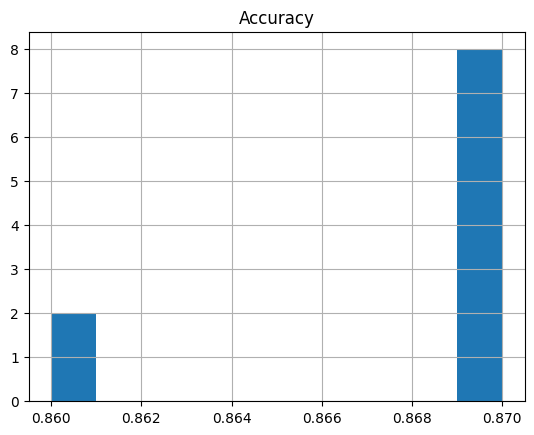

In [14]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]

 


# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  
  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")
  





  

In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/skyl1_LECO_d0.al", 'wb'))

Round 0


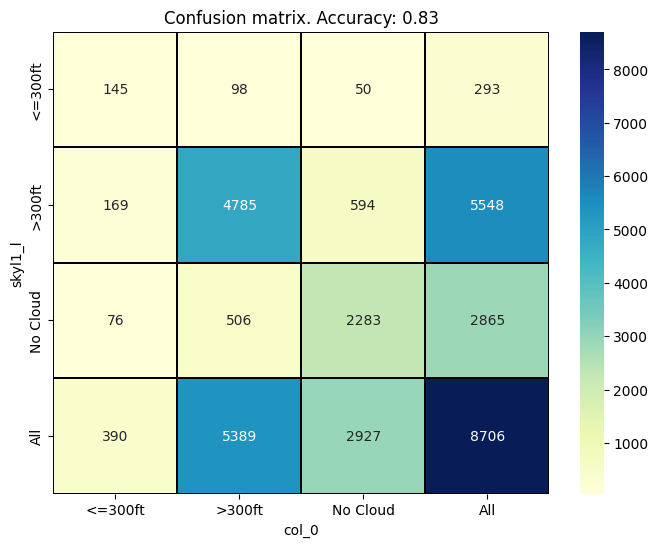

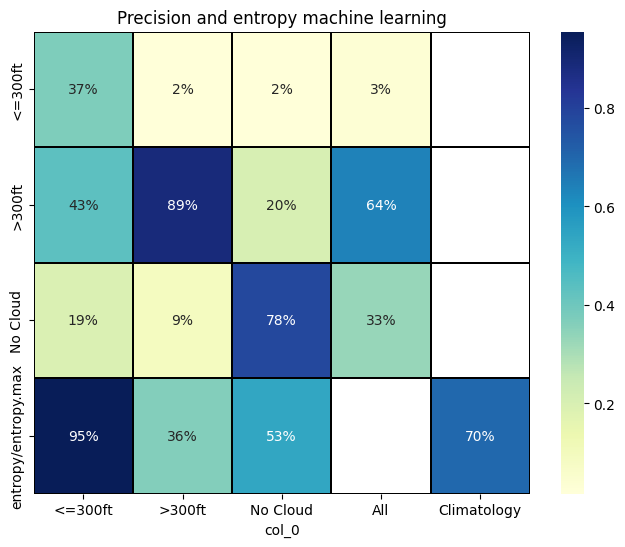

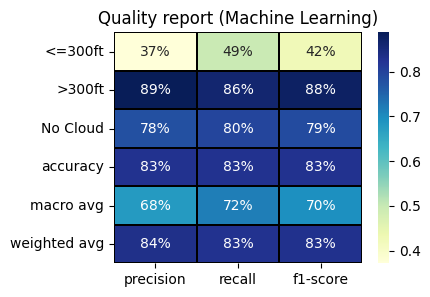

feature feature_per
102  dayofyear        4.3%
100       hour        2.9%
50        dir2        2.1%
0         dir0        1.9%
75        dir3        1.7%
7          rh0        1.6%
101      month        1.6%
57         rh2        1.6%
25        dir1        1.5%
64      shflx2        1.5%

Round 1


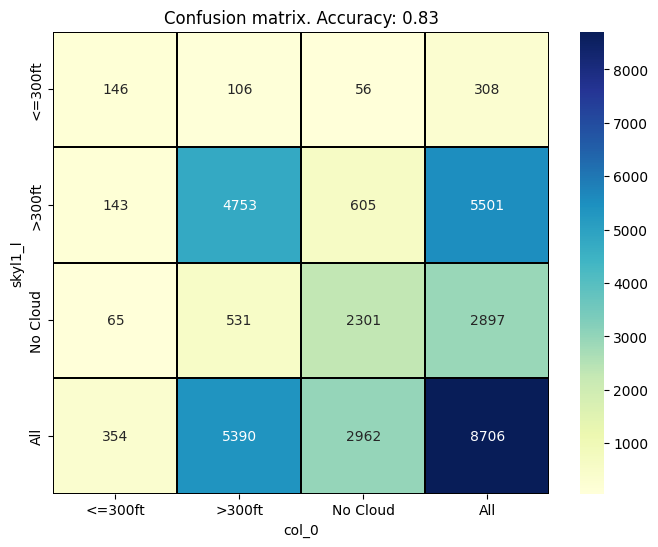

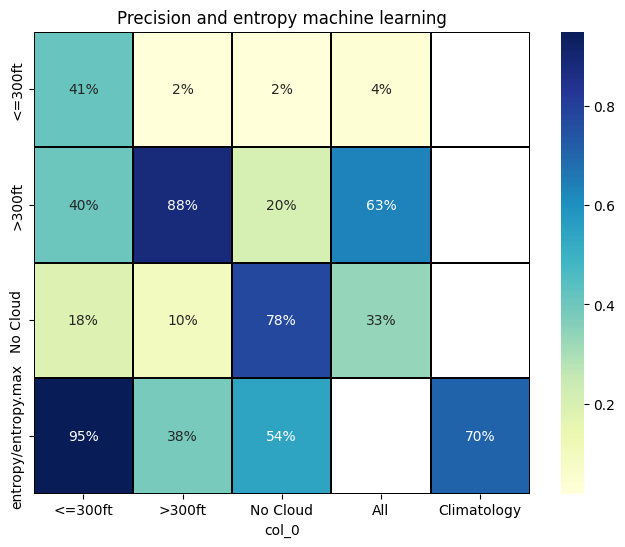

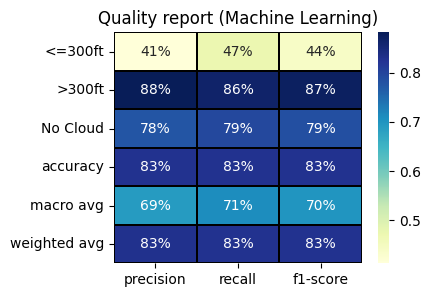

feature feature_per
102    dayofyear        4.7%
100         hour        3.1%
50          dir2        1.9%
75          dir3        1.8%
101        month        1.6%
58   visibility2        1.6%
0           dir0        1.6%
39        shflx1        1.5%
57           rh2        1.5%
7            rh0        1.5%

Round 2


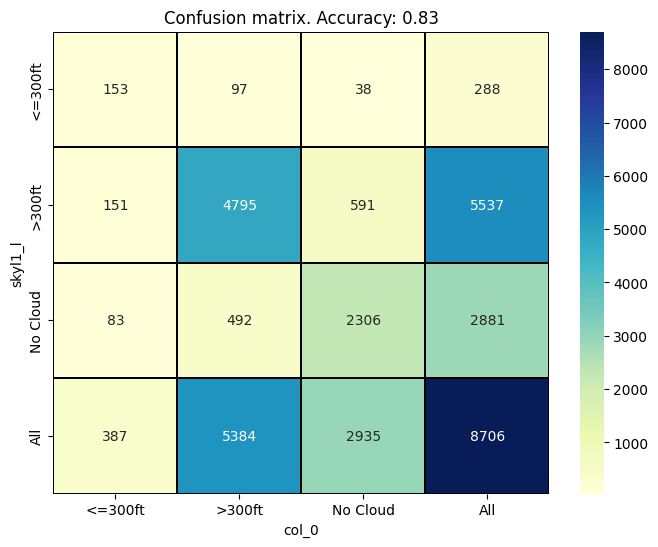

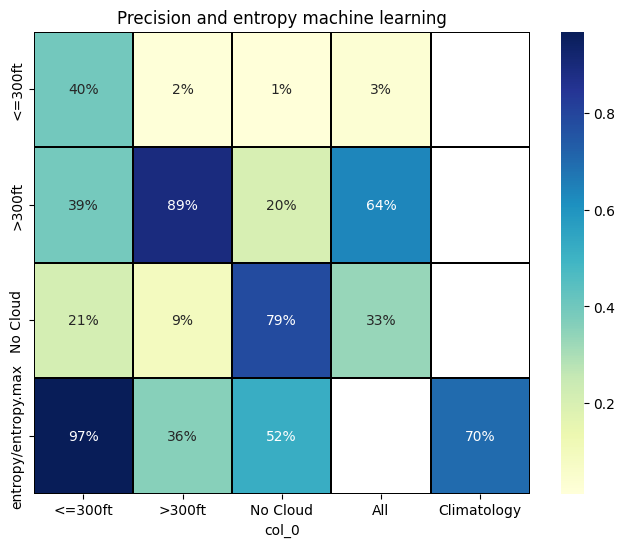

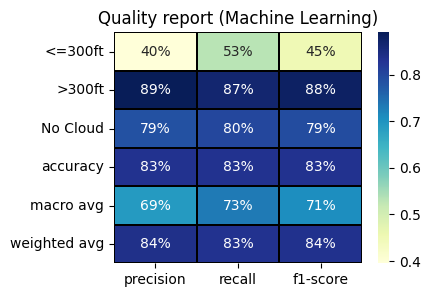

feature feature_per
102    dayofyear        4.9%
100         hour        3.0%
50          dir2        2.1%
0           dir0        1.9%
75          dir3        1.8%
58   visibility2        1.6%
57           rh2        1.6%
7            rh0        1.6%
39        shflx1        1.5%
101        month        1.5%

Round 3


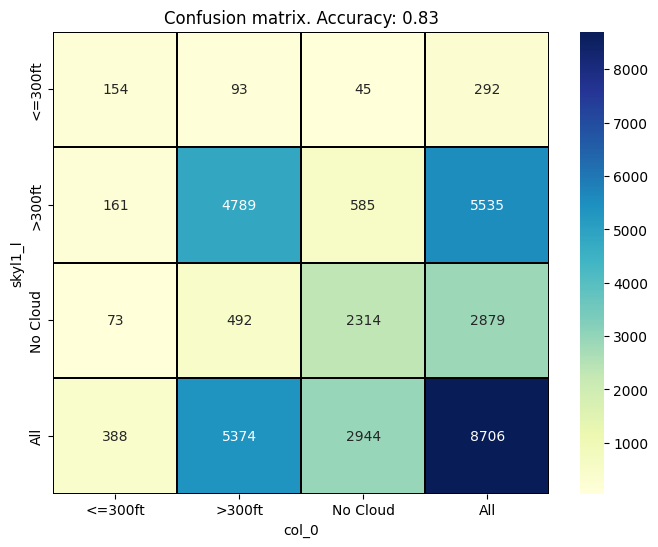

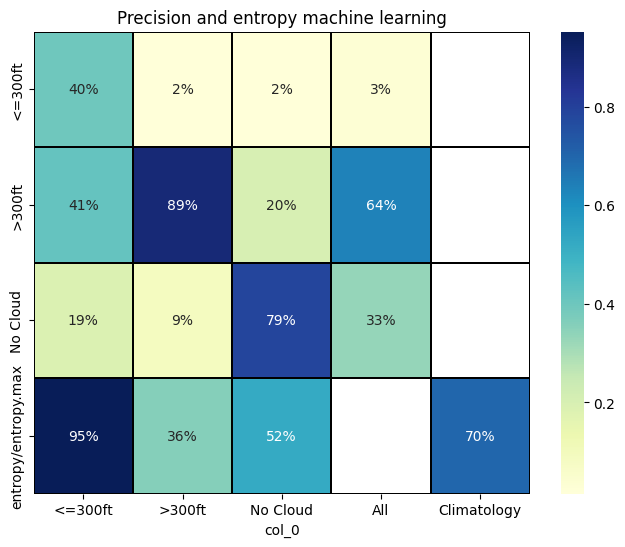

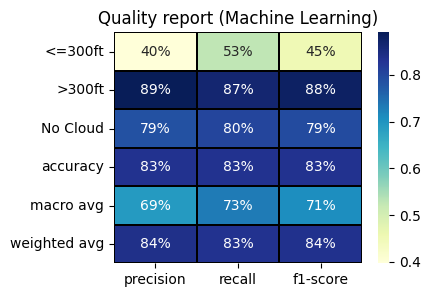

feature feature_per
102   dayofyear        5.2%
100        hour        3.1%
50         dir2        2.0%
0          dir0        1.8%
75         dir3        1.8%
101       month        1.7%
7           rh0        1.6%
57          rh2        1.5%
2    snowlevel0        1.5%
25         dir1        1.4%

Round 4


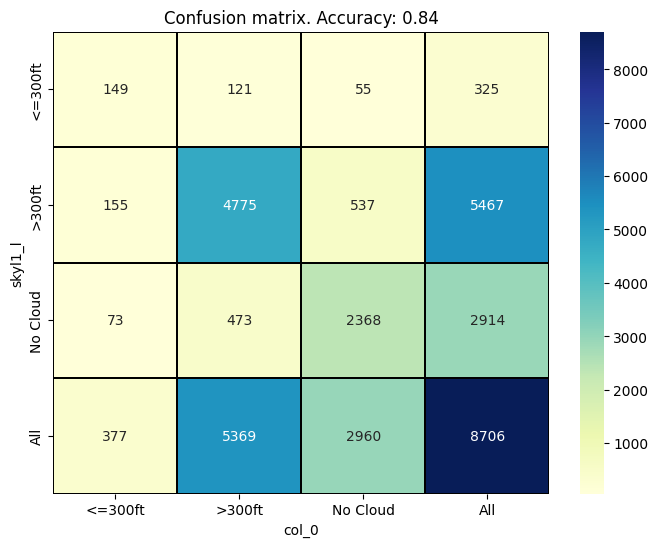

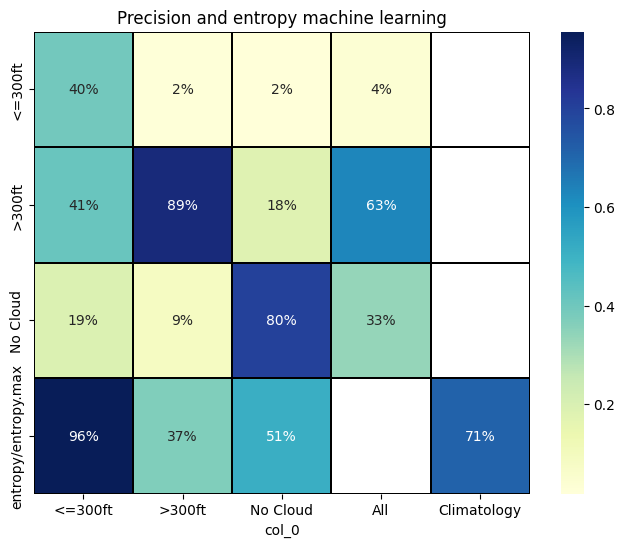

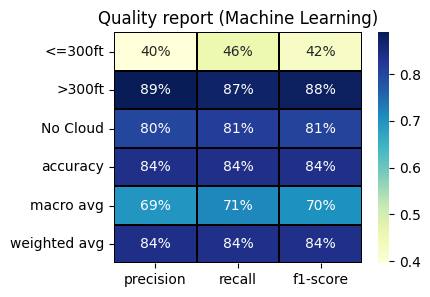

feature feature_per
102    dayofyear        4.7%
100         hour        3.0%
75          dir3        1.9%
50          dir2        1.8%
0           dir0        1.7%
101        month        1.7%
57           rh2        1.6%
64        shflx2        1.5%
54    wind_gust2        1.4%
33   visibility1        1.4%

Round 5


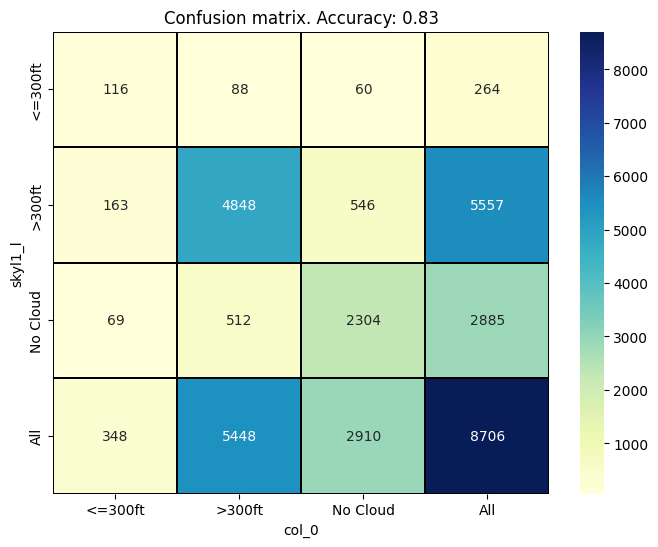

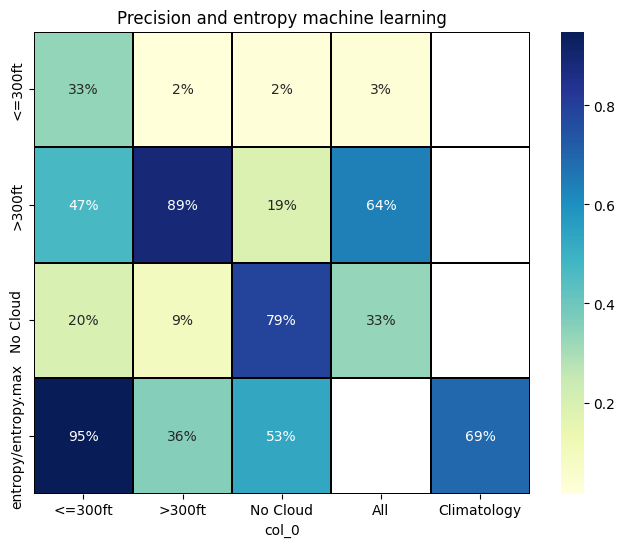

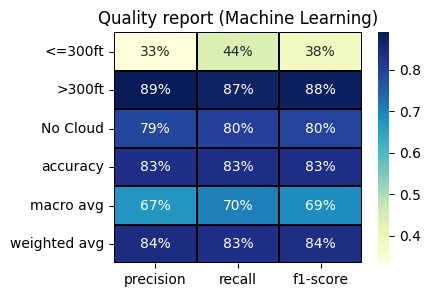

feature feature_per
102    dayofyear        5.0%
100         hour        2.8%
0           dir0        1.8%
50          dir2        1.8%
75          dir3        1.7%
57           rh2        1.7%
101        month        1.6%
33   visibility1        1.6%
7            rh0        1.6%
39        shflx1        1.5%

Round 6


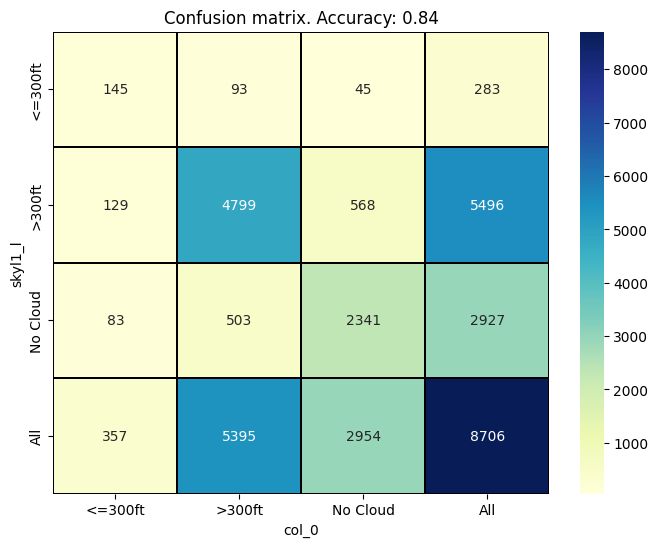

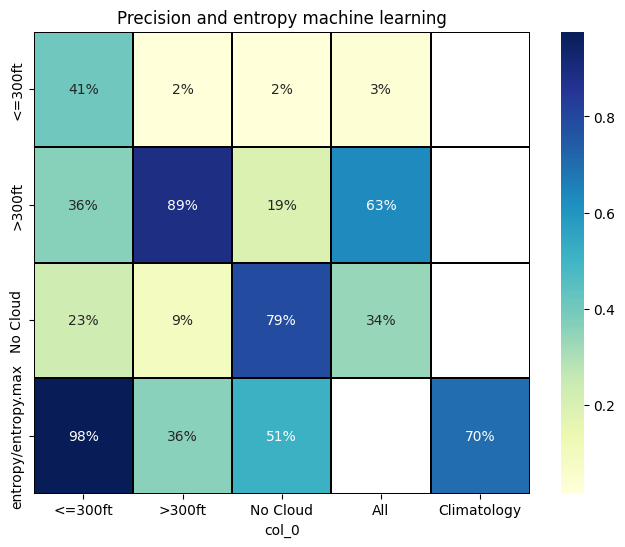

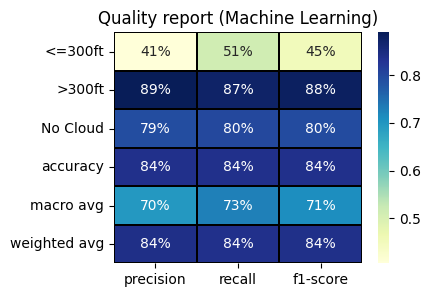

feature feature_per
102   dayofyear        4.7%
100        hour        3.1%
50         dir2        2.1%
0          dir0        1.8%
101       month        1.6%
57          rh2        1.6%
39       shflx1        1.5%
75         dir3        1.5%
7           rh0        1.5%
2    snowlevel0        1.5%

Round 7


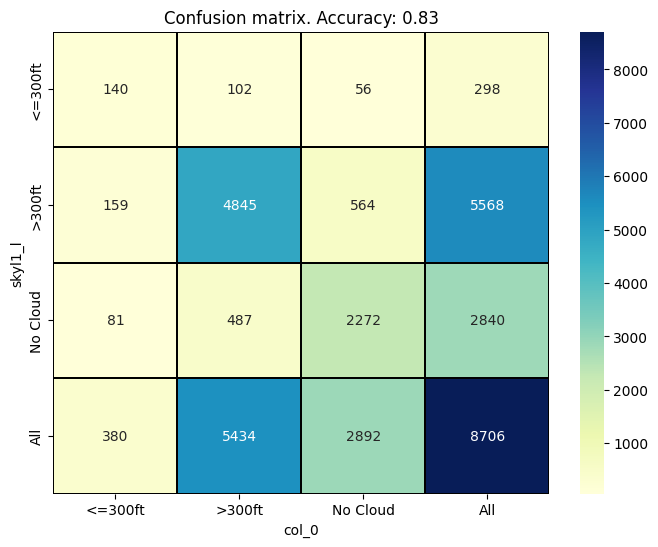

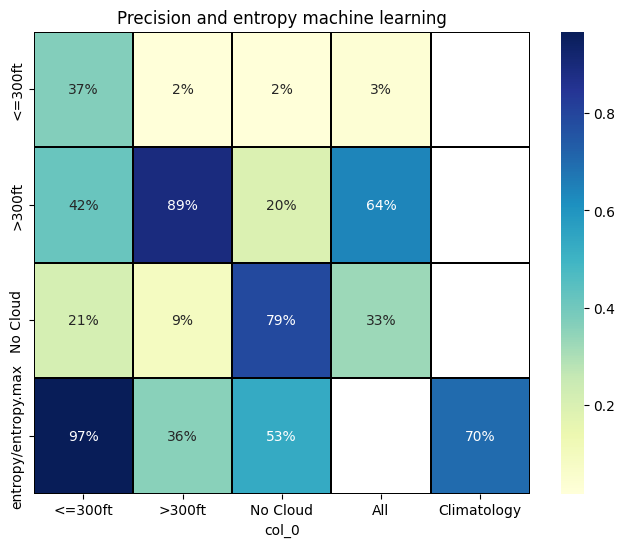

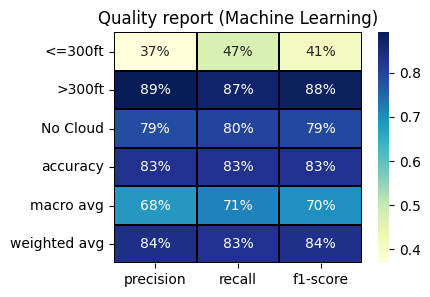

feature feature_per
102    dayofyear        4.7%
100         hour        3.0%
50          dir2        1.9%
0           dir0        1.9%
75          dir3        1.9%
33   visibility1        1.7%
7            rh0        1.7%
101        month        1.6%
57           rh2        1.5%
39        shflx1        1.5%

Round 8


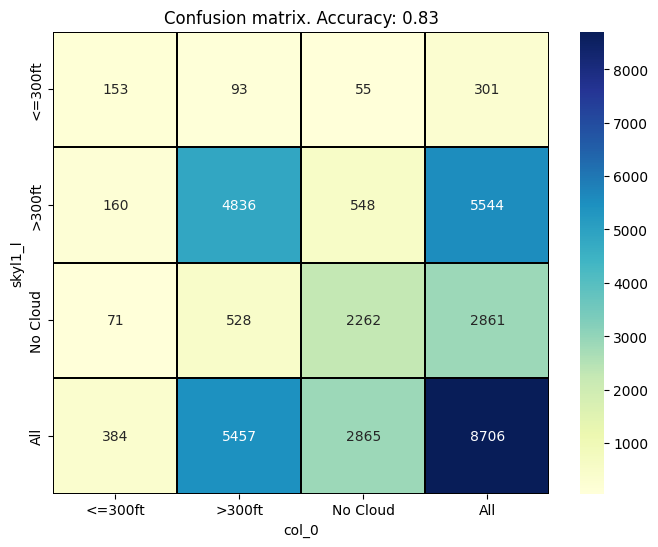

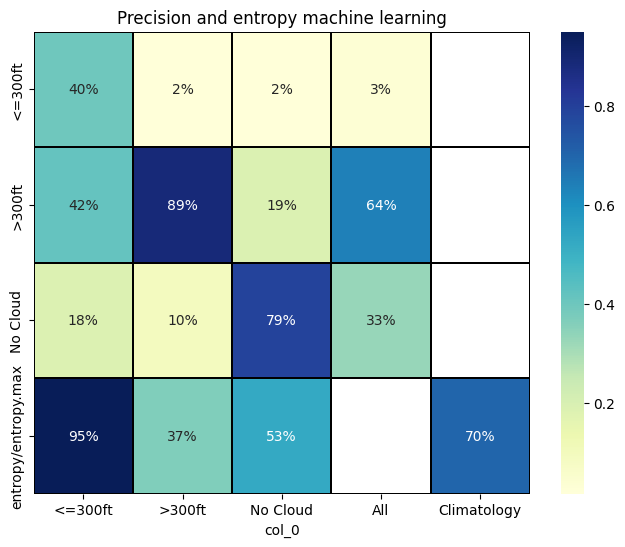

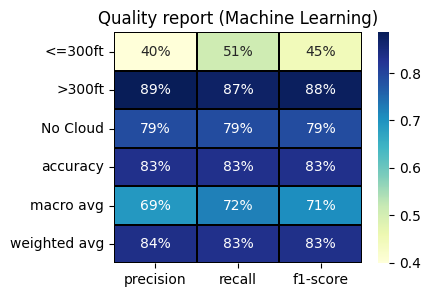

feature feature_per
102   dayofyear        4.7%
100        hour        3.0%
50         dir2        1.9%
0          dir0        1.8%
75         dir3        1.8%
27   snowlevel1        1.5%
101       month        1.5%
49        T8501        1.5%
57          rh2        1.5%
7           rh0        1.4%

Round 9


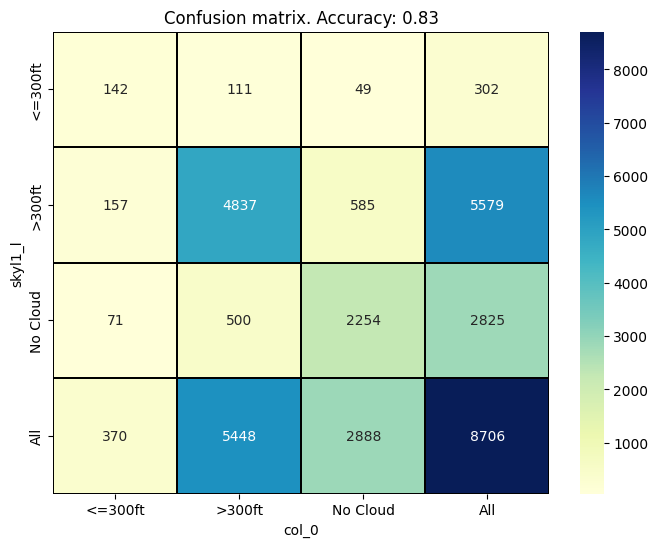

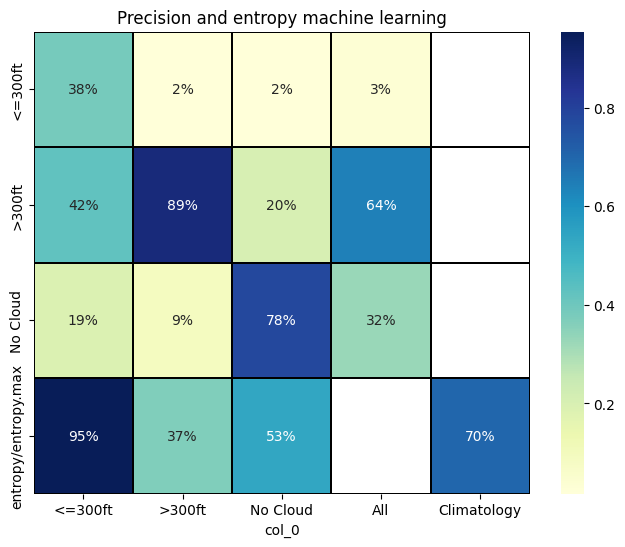

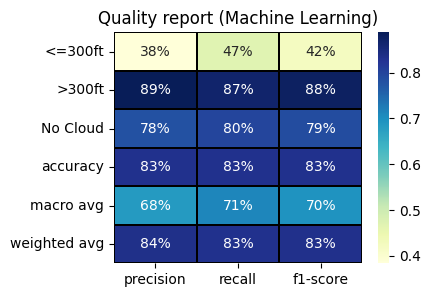

feature feature_per
102   dayofyear        4.7%
100        hour        3.3%
50         dir2        1.8%
0          dir0        1.7%
75         dir3        1.7%
57          rh2        1.7%
7           rh0        1.7%
101       month        1.5%
103  weekofyear        1.5%
54   wind_gust2        1.4%


Accuracy stadistics
        Accuracy
count  10.000000
mean    0.832000
std     0.004216
min     0.830000
25%     0.830000
50%     0.830000
75%     0.830000
max     0.840000
Shapiro test normality
p value: 4.6723621380806435e-06
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 2.186821842269409e-273
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1248.0640313776432
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 5.75 minutes


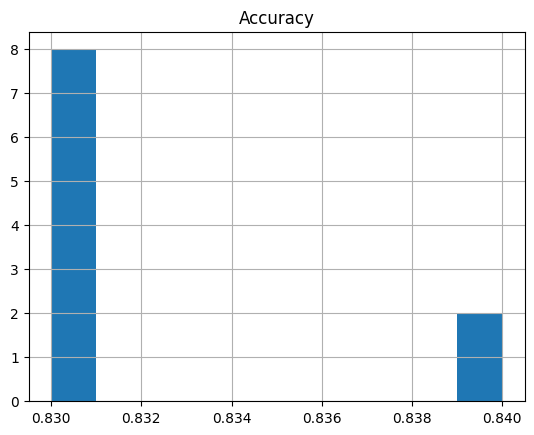

In [16]:
#@title Load meteorological model forecast D1. ML LGBMClassifier. Samples 10. Heidke Skill score.
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int) 

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]
 

# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  
  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")


In [18]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/skyl1_LECO_d1.al", 'wb'))